# Predicting productivity of garment employees

This project initially focuses on using regression type machine learning.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures

In [3]:
os.chdir(r'C:\Users\pigle\OneDrive\Documents\Data Science\Python Tutorials\Stats_Python')
df = pd.read_csv('garments_worker_productivity.csv') 
# this could also be useful: pd.read_csv('data.csv', na_values='.')

   ##  Overview 

In [4]:
df.sample(10)
df.shape
df.info()
df.describe(include=['O']) # O to include objects
df.describe().T # integers and floats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

,count,mean,std,min,25%,50%,75%,max
team,1197.0,6.426901,3.463963,1.000000,3.000000,6.000000,9.000000,12.000000
targeted_productivity,1197.0,0.729632,0.097891,0.070000,0.700000,0.750000,0.800000,0.800000
smv,1197.0,15.062172,10.943219,2.900000,3.940000,15.260000,24.260000,54.560000
wip,691.0,1190.465991,1837.455001,7.000000,774.500000,1039.000000,1252.500000,23122.000000
over_time,1197.0,4567.460317,3348.823563,0.000000,1440.000000,3960.000000,6960.000000,25920.000000
incentive,1197.0,38.210526,160.182643,0.000000,0.000000,0.000000,50.000000,3600.000000
idle_time,1197.0,0.730159,12.709757,0.000000,0.000000,0.000000,0.000000,300.000000
idle_men,1197.0,0.369256,3.268987,0.000000,0.000000,0.000000,0.000000,45.000000
no_of_style_change,1197.0,0.150376,0.427848,0.000000,0.000000,0.000000,0.000000,2.000000
no_of_workers,1197.0,34.609858,22.197687,2.000000,9.000000,34.000000,57.000000,89.000000


Some initial insights:
* The 'Teams' variable should be qualitative
* Median 'Actual productivity' is 0.77 (50 percentile)
* 'Targeted productivity' is slightly under forecasted

## (2) Data Wrangling

In [5]:
df['team'] = df['team'].apply(lambda x:str(x)) # make team int an object type
category = (df.select_dtypes(include='object')).copy()
numerical = (df.select_dtypes(exclude='object')).copy()

In [6]:
for c in category.columns:
    print(f"{c}")
    print(category[c].unique())
    print()

date
['1/1/2015' '1/3/2015' '1/4/2015' '1/5/2015' '1/6/2015' '1/7/2015'
 '1/8/2015' '1/10/2015' '1/11/2015' '1/12/2015' '1/13/2015' '1/14/2015'
 '1/15/2015' '1/17/2015' '1/18/2015' '1/19/2015' '1/20/2015' '1/21/2015'
 '1/22/2015' '1/24/2015' '1/25/2015' '1/26/2015' '1/27/2015' '1/28/2015'
 '1/29/2015' '1/31/2015' '2/1/2015' '2/2/2015' '2/3/2015' '2/4/2015'
 '2/5/2015' '2/7/2015' '2/8/2015' '2/9/2015' '2/10/2015' '2/11/2015'
 '2/12/2015' '2/14/2015' '2/15/2015' '2/16/2015' '2/17/2015' '2/18/2015'
 '2/19/2015' '2/22/2015' '2/23/2015' '2/24/2015' '2/25/2015' '2/26/2015'
 '2/28/2015' '3/1/2015' '3/2/2015' '3/3/2015' '3/4/2015' '3/5/2015'
 '3/7/2015' '3/8/2015' '3/9/2015' '3/10/2015' '3/11/2015']

quarter
['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']

department
['sweing' 'finishing ' 'finishing']

day
['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']

team
['8' '1' '11' '12' '6' '7' '2' '3' '9' '10' '5' '4']



In [7]:
df.department.value_counts() # spelling errors must be fixed

sweing        691
finishing     257
finishing     249
Name: department, dtype: int64

In [8]:
category.loc[:,'department'] = category.loc[:,'department'].str.strip() # removing error in 'finishing' 
category['department']=category['department'].replace(['sweing'],['sewing']) # fixing spelling
# alternative code:(lambda x: 'finishing' if x == ('finishing ' or 'finishing' ) else 'sewing' )
category.department.value_counts() 

sewing       691
finishing    506
Name: department, dtype: int64

In [9]:
numerical.isnull().sum()

targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [10]:
numerical[numerical.isnull().any(axis=1)] # these entries all have NAs 

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
6,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.755167
13,0.65,3.94,NaN,960,0,0.0,0,0,8.0,0.705917
14,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.676667
15,0.75,3.94,NaN,2160,0,0.0,0,0,18.0,0.593056
...,...,...,...,...,...,...,...,...,...,...
1192,0.75,2.90,NaN,960,0,0.0,0,0,8.0,0.628333
1193,0.70,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1194,0.65,3.90,NaN,960,0,0.0,0,0,8.0,0.625625
1195,0.75,2.90,NaN,1800,0,0.0,0,0,15.0,0.505889


In [11]:
numerical['wip'] = numerical['wip'].fillna(value=0.0) # fill NaNs with float64 
category[category.isnull().any(axis=1)]['department'].unique() # checks for NaN values
df2 = pd.concat([category, numerical],axis=1) # combining back the cleaned numerical and object variables

## (3) Basic Visualisations

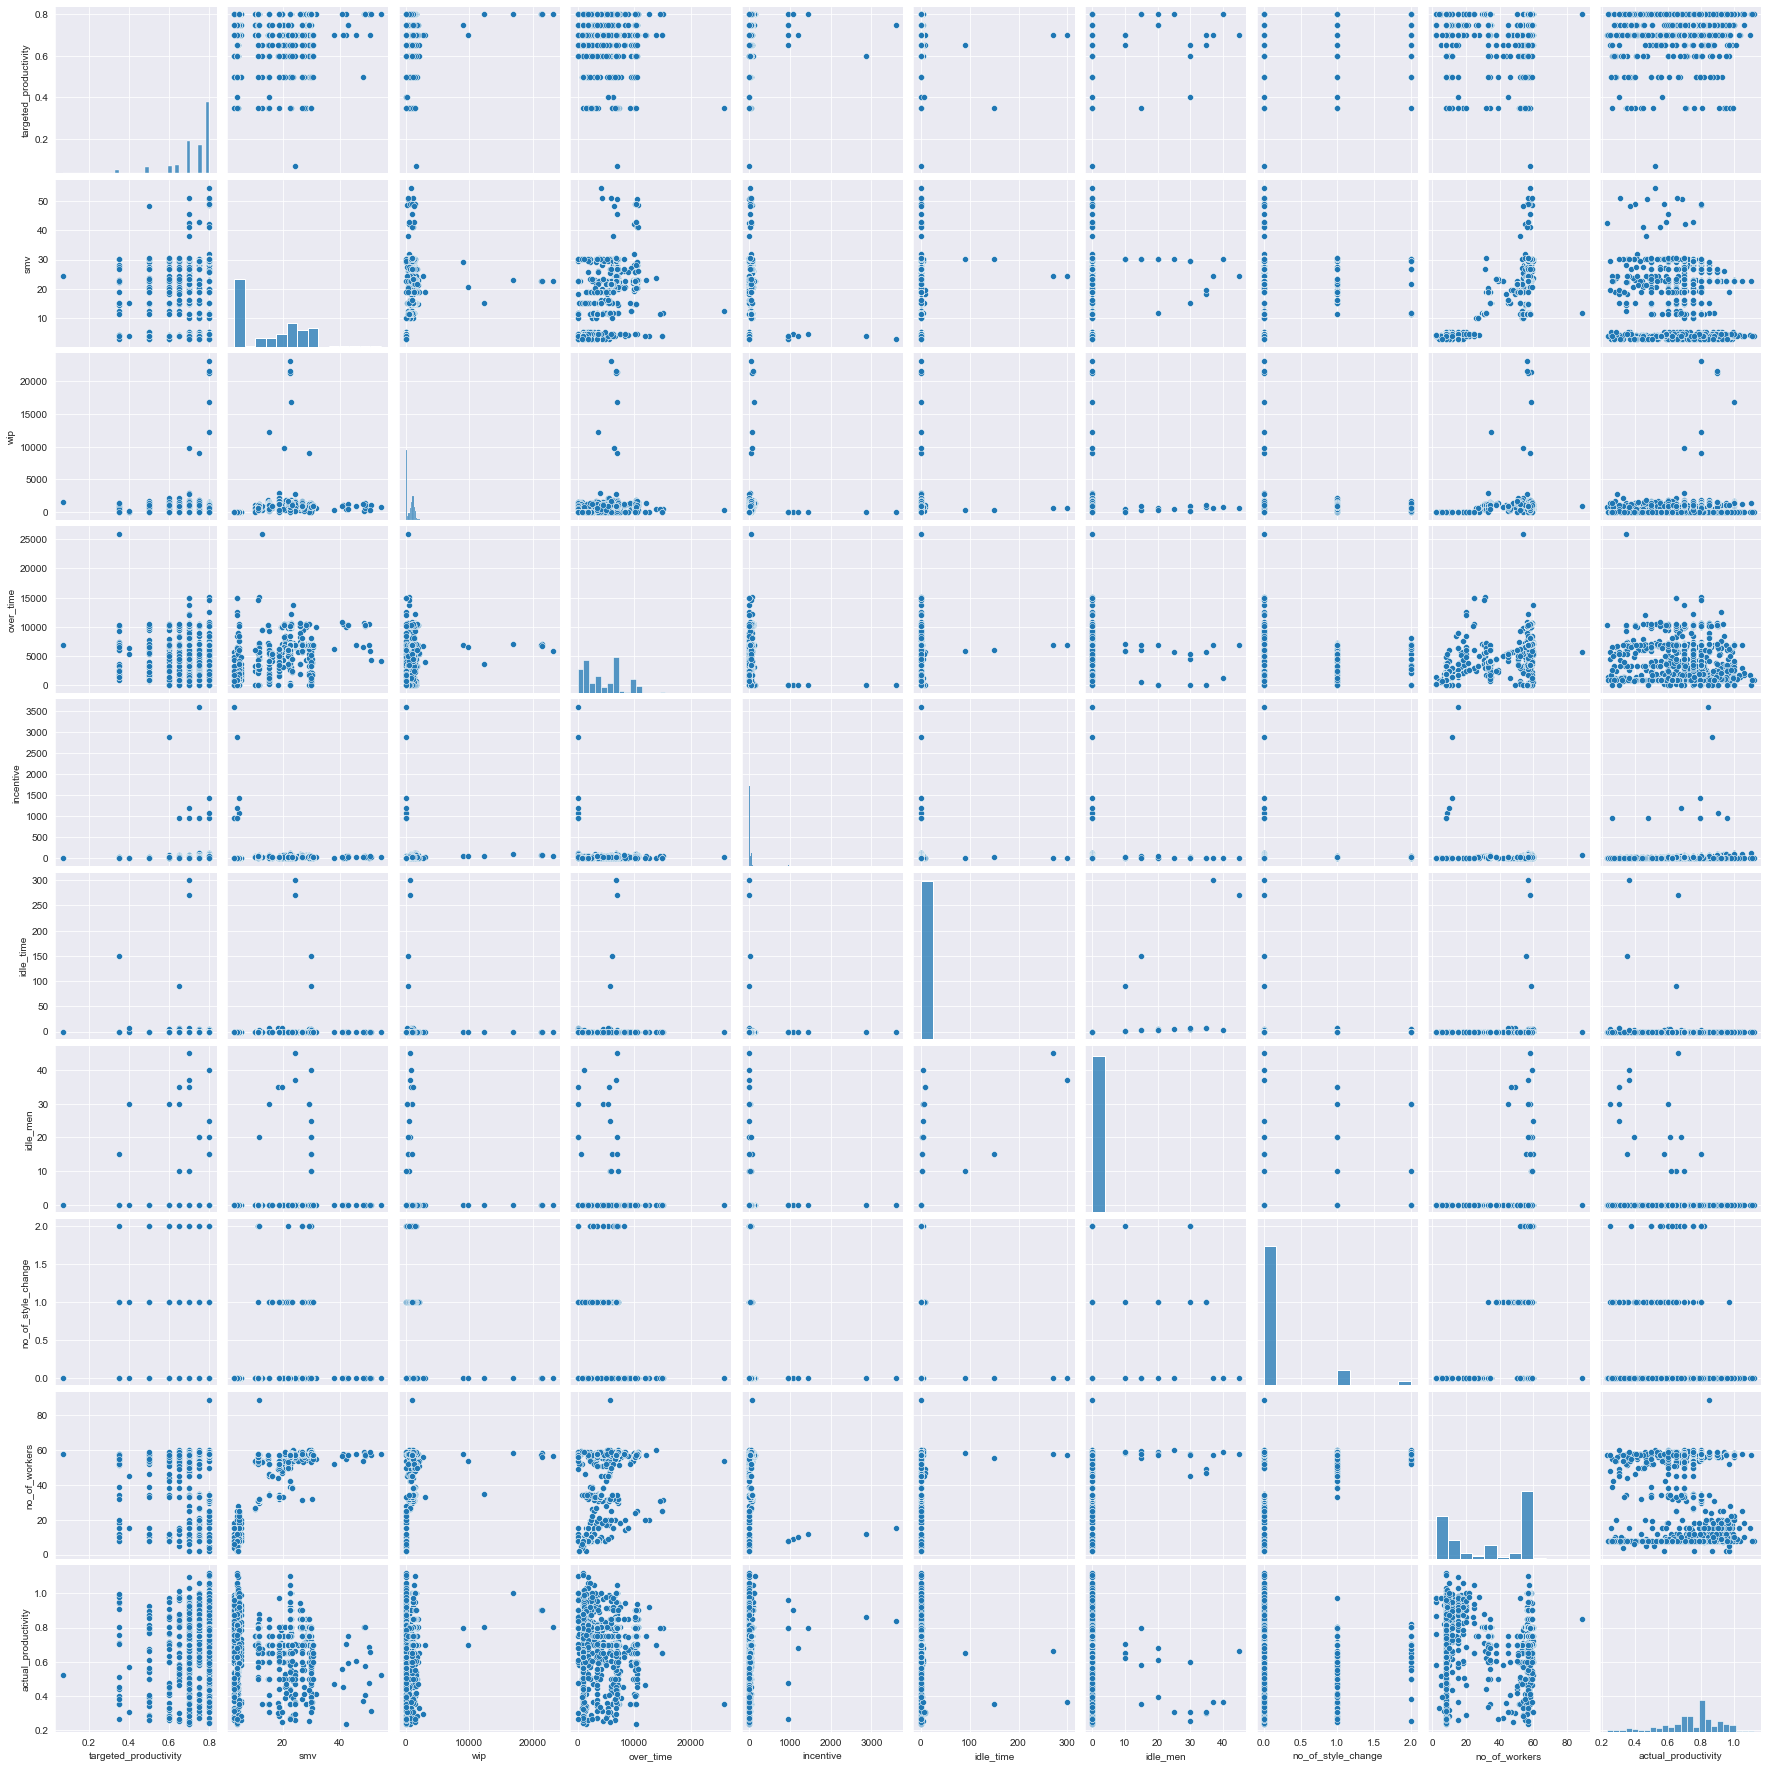

In [12]:
sns.pairplot(df2)

The pairplot gives an idea of where there may be feature variables that are collinear - where two or more variables are highly linearly correlated with one another. 

Meaning regression coefficients are not uniquely determined, hurting the interpretability of the model as then the regression coefficients are not unique and have influences from other features. The ability to interpret models is a key part of being a Data Scientist.

<AxesSubplot:ylabel='Count'>

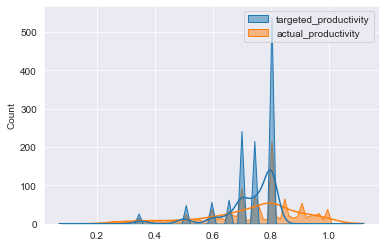

In [13]:
sns.histplot(data=df2[['targeted_productivity', 'actual_productivity']],
             element='poly', kde=(True))

Text(0.5, 1.0, 'Department Split')

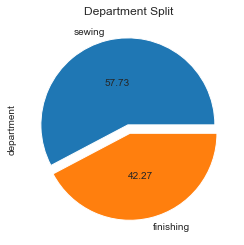

In [14]:
df2['department'].value_counts().plot(kind='pie', autopct='%.2f', 
                                      pctdistance=0.5, explode=[0.05]*2)
plt.title('Department Split')

Text(0.5, 1.0, 'Quarters')

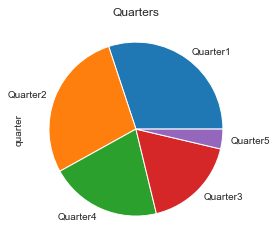

In [15]:
df2['quarter'].value_counts().plot(kind='pie')
plt.title('Quarters')

Text(0.5, 0, 'Frequency')

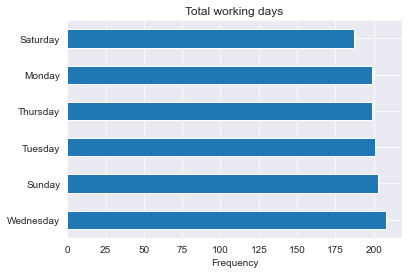

In [16]:
category['day'].value_counts().plot(kind='barh')
plt.title('Total working days')
plt.xlabel('Frequency')

Text(0, 0.5, 'Average Overtime')

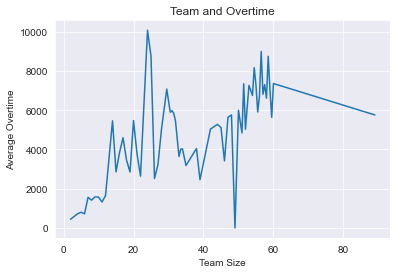

In [17]:
x_axis = df2['no_of_workers'].unique()
y_axis = []
for val in x_axis:
    y_axis.append(df2['over_time'][df['no_of_workers'] == val].mean())
sns.lineplot(x=x_axis, y=y_axis)
plt.title('Team and Overtime')
plt.xlabel('Team Size')
plt.ylabel('Average Overtime')

## (4) Exploring correlation & selecting significant features

<AxesSubplot:>

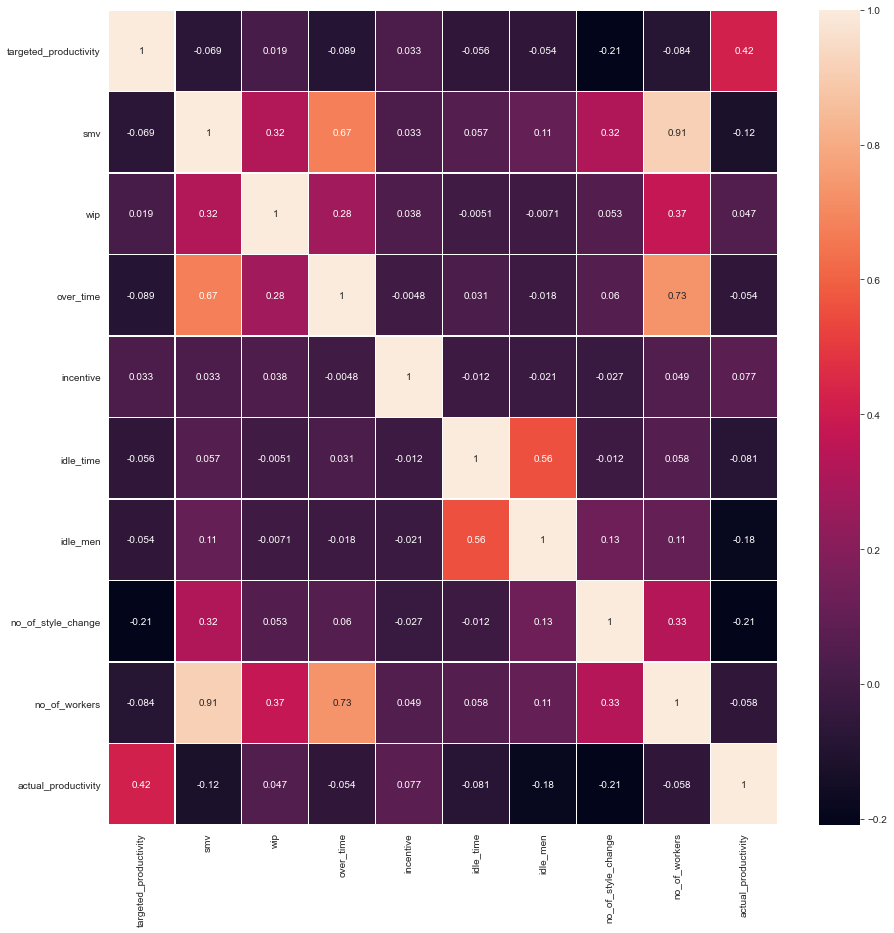

In [18]:
corrMatrix = numerical.corr()
fig, ax = plt.subplots(figsize=(15,15)) #sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)
# no_of_workers & smv are collinear, having a high correlation coefficient between themselves

In [19]:
pd.Series.nunique(df2['team']) # checks how many new dummy columns will be created from distinct values

12

In [20]:
df2 = pd.get_dummies(df2, drop_first=True, columns=['day','department','quarter','team'])
# drops first column to remove redundancy k-1 dummies

<AxesSubplot:>

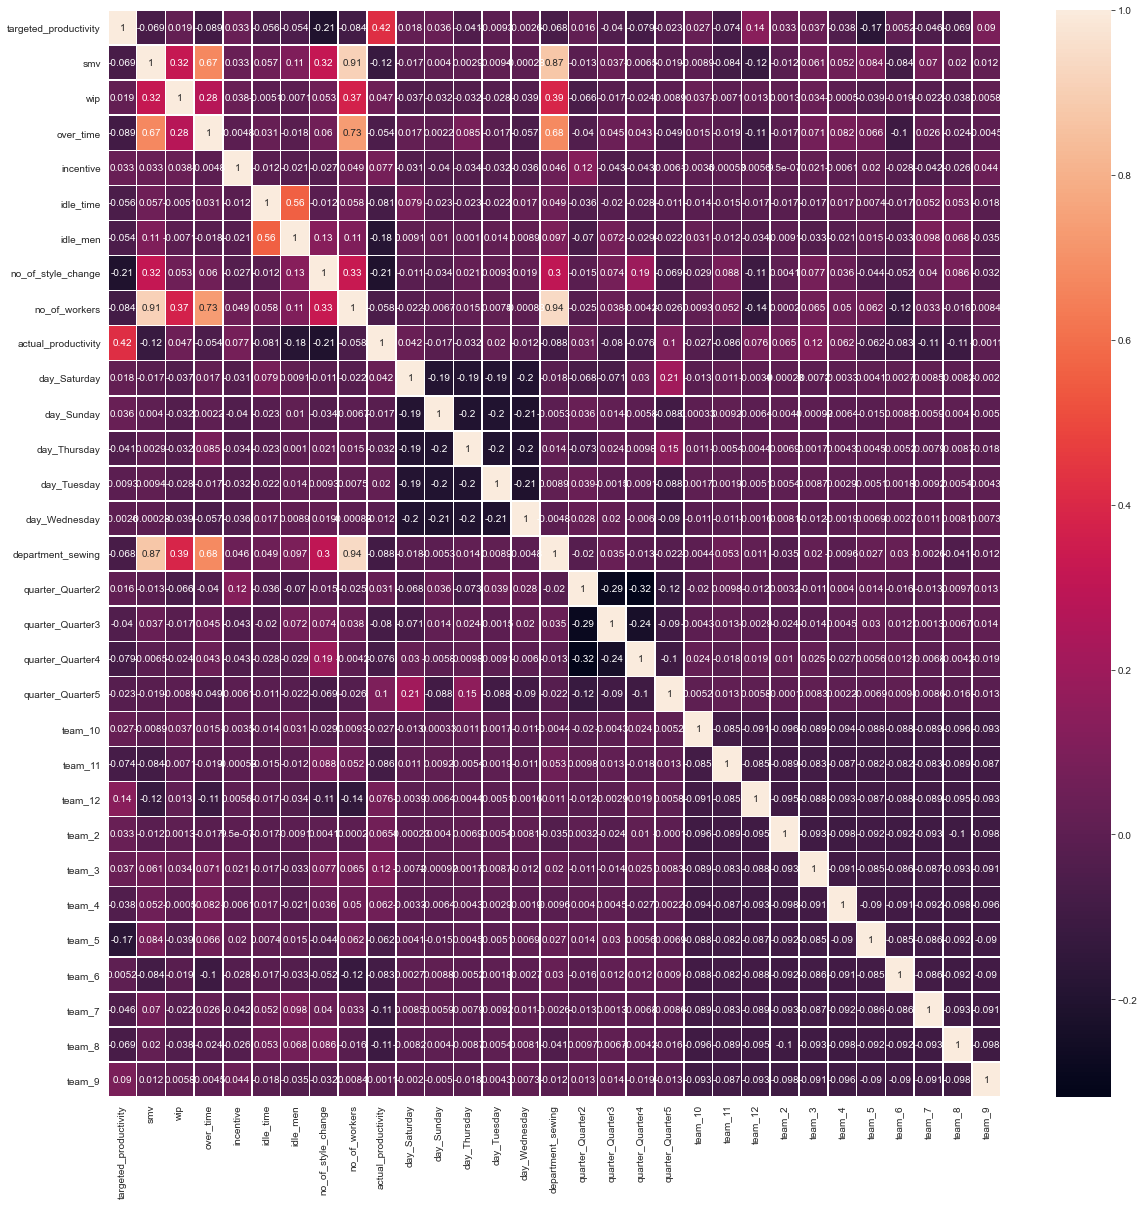

In [21]:
corrMatrix2 = df2.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(corrMatrix2, annot=True, linewidths=.5, ax=ax)

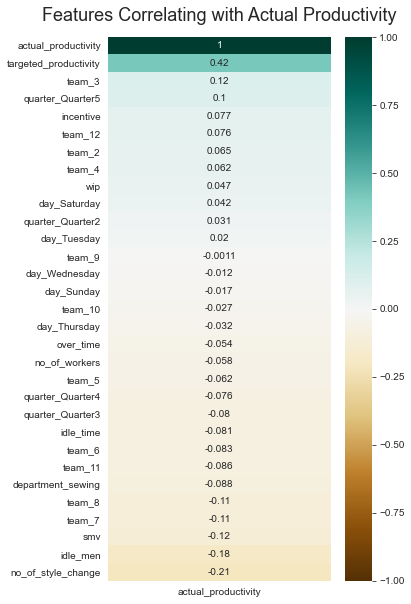

In [22]:
plt.figure(figsize=(5,10))
heatmap = sns.heatmap(corrMatrix2[['actual_productivity']].sort_values(
    by='actual_productivity', ascending=False), vmin=-1, vmax=1, annot=True,
    cmap='BrBG')
heatmap.set_title('Features Correlating with Actual Productivity',
                  fontdict={'fontsize': 18}, pad=16);

The productivity correlation reveals more variables having non-significant relationships with productivity and so can be removed.

In [23]:
productivity_corr = pd.DataFrame(corrMatrix2[['actual_productivity']])
significant = productivity_corr[abs(productivity_corr) >= 0.05]
significant['use'] = significant['actual_productivity'].notna()
non_significant = significant[significant['use'] == False]
significant_col = significant.index[significant['use']].tolist()
non_sig_col = non_significant.index[non_significant['use'] == False].tolist()
significant_col.remove('actual_productivity')
non_sig_col.append('no_of_workers') # due to collinearity with smv
non_sig_col.append('department_sewing') # collinear with smv

In [24]:
pd.isnull(df2['idle_time']).count()

1197

In [25]:
non_sig_col.append('idle_time') # following two have high frequency of 0 s 
non_sig_col.append('idle_men')
non_sig_col

['wip',
 'day_Saturday',
 'day_Sunday',
 'day_Thursday',
 'day_Tuesday',
 'day_Wednesday',
 'quarter_Quarter2',
 'team_10',
 'team_9',
 'no_of_workers',
 'department_sewing',
 'idle_time',
 'idle_men']

In [26]:
df2.drop(columns=non_sig_col, inplace=True)
df2.drop(columns='date', inplace=True)
X = np.array(df2.drop(columns='actual_productivity')) # converts df type to array for clustering

## (5) The Elbow Method (k-means) 
Deciding How Many Principal Components to Use - We choose the smallest number of principal components that are required in order to explain a sizable amount of the variation in the data. This is done by eyeballing the scree plot, and looking for a point at which the proportion of variance explained by each subsequent principal component drops off. This drop is often referred to as an elbow in the scree plot.

In [27]:
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
from sklearn.decomposition import PCA

In [28]:
distortions = [] #calculate distortion for a range of clusters
figure(figsize=(16, 8), dpi=80)

for i in range(1, 16):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X)
    distortions.append(km.inertia_)

<Figure size 1280x640 with 0 Axes>

Text(0, 0.5, 'Distortion')

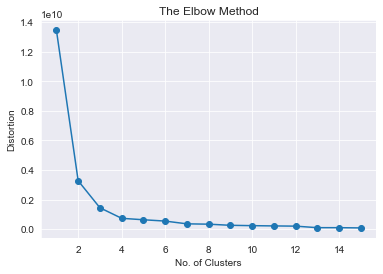

In [29]:
plt.plot(range(1,16), distortions, marker='o')
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Distortion')

In [30]:
# using above Elbow Method for K-means clustering we find optimal no. of clusters = 5
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
df2['cluster'] = kmeans.labels_
X = df2.drop(columns='actual_productivity') # X used with the model

## (6) PCA - dimensionality reduction method

In [31]:
reduced_data = PCA(n_components=2).fit_transform(X)
results = pd.DataFrame(reduced_data, columns=['PCA1','PCA2'])
centroids = np.array(kmeans.cluster_centers_)

Text(0.5, 1.0, 'K-means CLustering - 2 Dimensions')

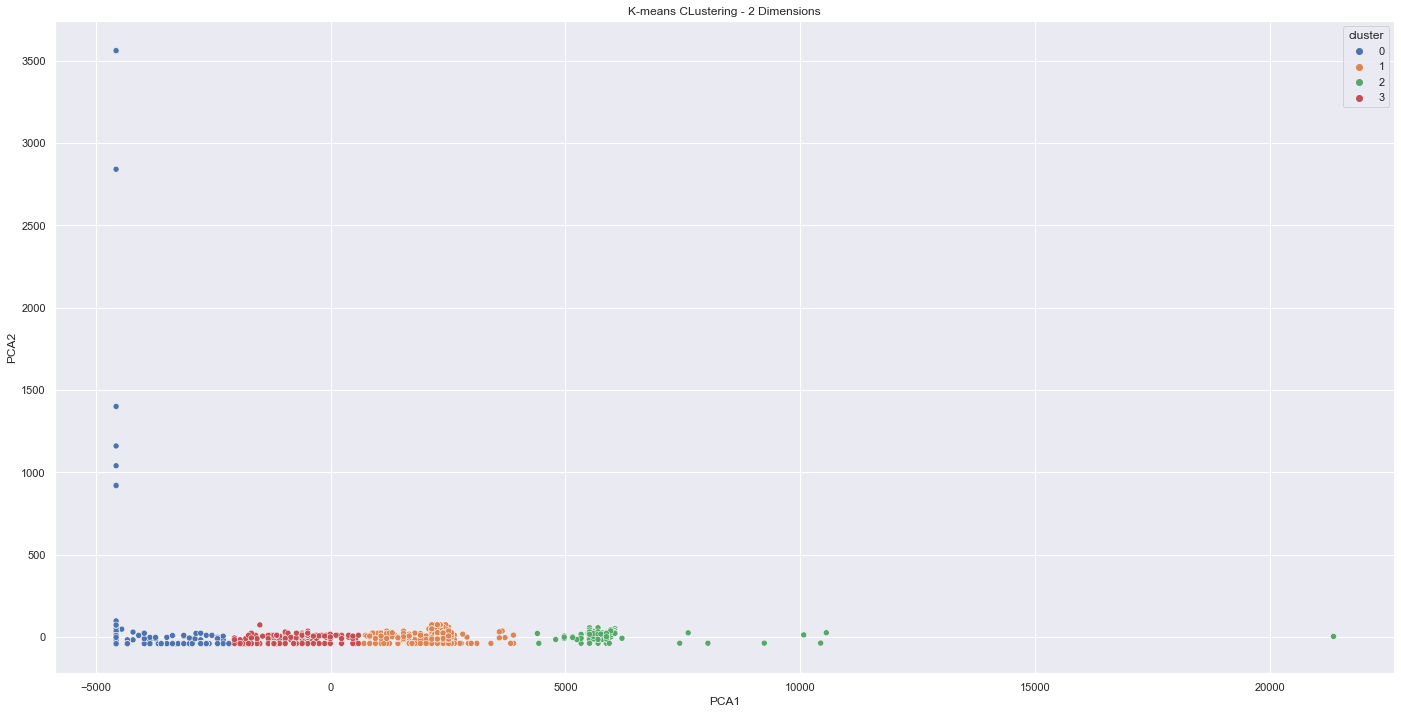

In [32]:
sns.set_theme(rc={'figure.figsize': (24,12)})
sns.scatterplot(x='PCA1', y='PCA2', hue=X['cluster'],data=results, 
                palette='deep')
plt.title('K-means CLustering - 2 Dimensions')

Having determined optimal clusters as 4 and performing kMeans clustering on this pre-initialised number. The clusters (hue) can be overlayed onto the data, dimensionally reduced to 2 dimensions with PCA.

By removing the highest correlation among the variables, there is no redundany to reduce! Therefore the PCA-reduced dataset can disregarded. However, as kMeans generated and from it we determined optimal clusters, they can be used as train and test subsets.

## (7) Building predictive models - splitting train/test and Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

In [34]:
x0 = df2[df2['cluster'] == 0].drop(columns='actual_productivity')
y0 = df2[df2['cluster'] == 0].actual_productivity
x0_train, x0_test, y0_train, y0_test = train_test_split(x0,y0,test_size=0.15,
                                                        random_state=0)
X1 = df2[df2['cluster'] == 1 ].drop(columns='actual_productivity')
y1 = df2[df2['cluster'] == 1 ].actual_productivity
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.15, 
                                                        random_state= 0)
X2 = df2[df2['cluster'] == 2 ].drop(columns='actual_productivity')
y2 = df2[df2['cluster'] == 2 ].actual_productivity
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.15, 
                                                        random_state= 0)
X3 = df2[df2['cluster'] == 3 ].drop(columns='actual_productivity')
y3 = df2[df2['cluster'] == 3 ].actual_productivity
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.15, 
                                                        random_state= 0)

In [35]:
cluster0 = []
cluster1 = []
cluster2 = []
cluster3 = []

In [36]:
# cluster #0
lin_reg = LinearRegression()
lin_reg.fit(x0_train, y0_train)
# prediction using test set
y0_pred = lin_reg.predict(x0_test)
mae = metrics.mean_absolute_error(y0_test, y0_pred)
mse = metrics.mean_squared_error(y0_test, y0_pred)
# printing the metrics
print('Linear Regression for Cluster 0:')
print('R2 Square:', metrics.r2_score(y0_test, y0_pred))
cluster0.append(metrics.r2_score(y0_test, y0_pred))
print ('MAE: ', mae)
print ('MSE: ', mse)
print('')

Linear Regression for Cluster 0:
R2 Square: -0.05109049115183484
MAE:  0.14118468741088902
MSE:  0.03217643796924122



In [37]:
# Cluster #1
lin_reg = LinearRegression()
lin_reg.fit(X1_train,y1_train)
#Prediction using test set 
y1_pred = lin_reg.predict(X1_test)
mae=metrics.mean_absolute_error(y1_test, y1_pred)
mse=metrics.mean_squared_error(y1_test, y1_pred)
# Printing the metrics
print('Linear Regression for Cluster #1:')
print('R2 square:',metrics.r2_score(y1_test, y1_pred))
cluster1.append(metrics.r2_score(y1_test, y1_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

# Cluster #2
lin_reg = LinearRegression()
lin_reg.fit(X2_train,y2_train)
#Prediction using test set 
y2_pred = lin_reg.predict(X2_test)
mae=metrics.mean_absolute_error(y2_test, y2_pred)
mse=metrics.mean_squared_error(y2_test, y2_pred)
# Printing the metrics
print('Linear Regression for Cluster #2:')
print('R2 square:',metrics.r2_score(y2_test, y2_pred))
cluster2.append(metrics.r2_score(y2_test, y2_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

# Cluster #3
lin_reg = LinearRegression()
lin_reg.fit(X3_train,y3_train)
#Prediction using test set 
y3_pred = lin_reg.predict(X3_test)
mae=metrics.mean_absolute_error(y3_test, y3_pred)
mse=metrics.mean_squared_error(y3_test, y3_pred)
# Printing the metrics
print('Linear Regression for Cluster #3:')
print('R2 square:',metrics.r2_score(y3_test, y3_pred))
cluster3.append(metrics.r2_score(y3_test, y3_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

Linear Regression for Cluster #1:
R2 square: 0.731027458052807
MAE:  0.06695440332121355
MSE:  0.008132878487978721

Linear Regression for Cluster #2:
R2 square: 0.7983094903361254
MAE:  0.028250782591912958
MSE:  0.001808245056079165

Linear Regression for Cluster #3:
R2 square: 0.3893159098988558
MAE:  0.11982502560683092
MSE:  0.02594961399224147



## (8) Random Forest Regression

Random Forests are reliable and effective, very often outperforming linear regression. There are few reasons when LR is better - when the underlying function is truly linear, which above visualisations proved absent.

In [38]:
from sklearn.ensemble import RandomForestRegressor
#cluster #0
rf_regressor = RandomForestRegressor(n_estimators = 300, random_state=0)
rf_regressor.fit(x0_train,y0_train)
# predicting actual productivity from selected features
y0_pred = rf_regressor.predict(x0_test)
mae = metrics.mean_absolute_error(y0_test, y0_pred)
mse = metrics.mean_squared_error(y0_test, y0_pred)
# Printing the metrics
print('Random Forest Regression for Cluster #0:')
print('R2 square:',metrics.r2_score(y0_test, y0_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

Random Forest Regression for Cluster #0:
R2 square: 0.10083346111150582
MAE:  0.12819069022156726
MSE:  0.02752567605369345



In [39]:
# Cluster #1
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(X1_train,y1_train)
#Predicting the SalePrices using test set 
y1_pred = rf_regressor.predict(X1_test)
mae=metrics.mean_absolute_error(y1_test, y1_pred)
mse=metrics.mean_squared_error(y1_test, y1_pred)
# Printing the metrics
print('Random Forest Regression for Cluster #1:')
print('R2 square:',metrics.r2_score(y1_test, y1_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

# Cluster #2
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(X2_train,y2_train)
#Predicting the SalePrices using test set 
y2_pred = rf_regressor.predict(X2_test)
mae=metrics.mean_absolute_error(y2_test, y2_pred)
mse=metrics.mean_squared_error(y2_test, y2_pred)
# Printing the metrics
print('Random Forest Regression for Cluster #2:')
print('Suppport Vector Regression Accuracy: ', rf_regressor.score(X2_test,y2_test))
print('R2 square:',metrics.r2_score(y2_test, y2_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

# Cluster #3
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(X3_train,y3_train)
#Predicting the SalePrices using test set 
y3_pred = rf_regressor.predict(X3_test)
mae=metrics.mean_absolute_error(y3_test, y3_pred)
mse=metrics.mean_squared_error(y3_test, y3_pred)
# Printing the metrics
print('Random Forest Regression for Cluster #3:')
print('R2 square:',metrics.r2_score(y3_test, y3_pred))
print('MAE: ', mae)
print('MSE: ', mse)
print('')

Random Forest Regression for Cluster #1:
R2 square: 0.7597367661425267
MAE:  0.05230251654732096
MSE:  0.00726479986375441

Random Forest Regression for Cluster #2:
Suppport Vector Regression Accuracy:  0.790051611501554
R2 square: 0.790051611501554
MAE:  0.022156407124928116
MSE:  0.001882280609865011

Random Forest Regression for Cluster #3:
R2 square: 0.6011855792605241
MAE:  0.08335718365534998
MSE:  0.016946700332433284



Understanding how an individual Decision Tree is built and then, the concept of ensemble bagging, is enough to understand and  random forest models and tweak the hyperparameters.

However, Machine learning suffers from a black box problem so visualising some of the RF's trees can help demonstrate splitting which variables facilitated the bigger distributions in reaching a purer target variable. 

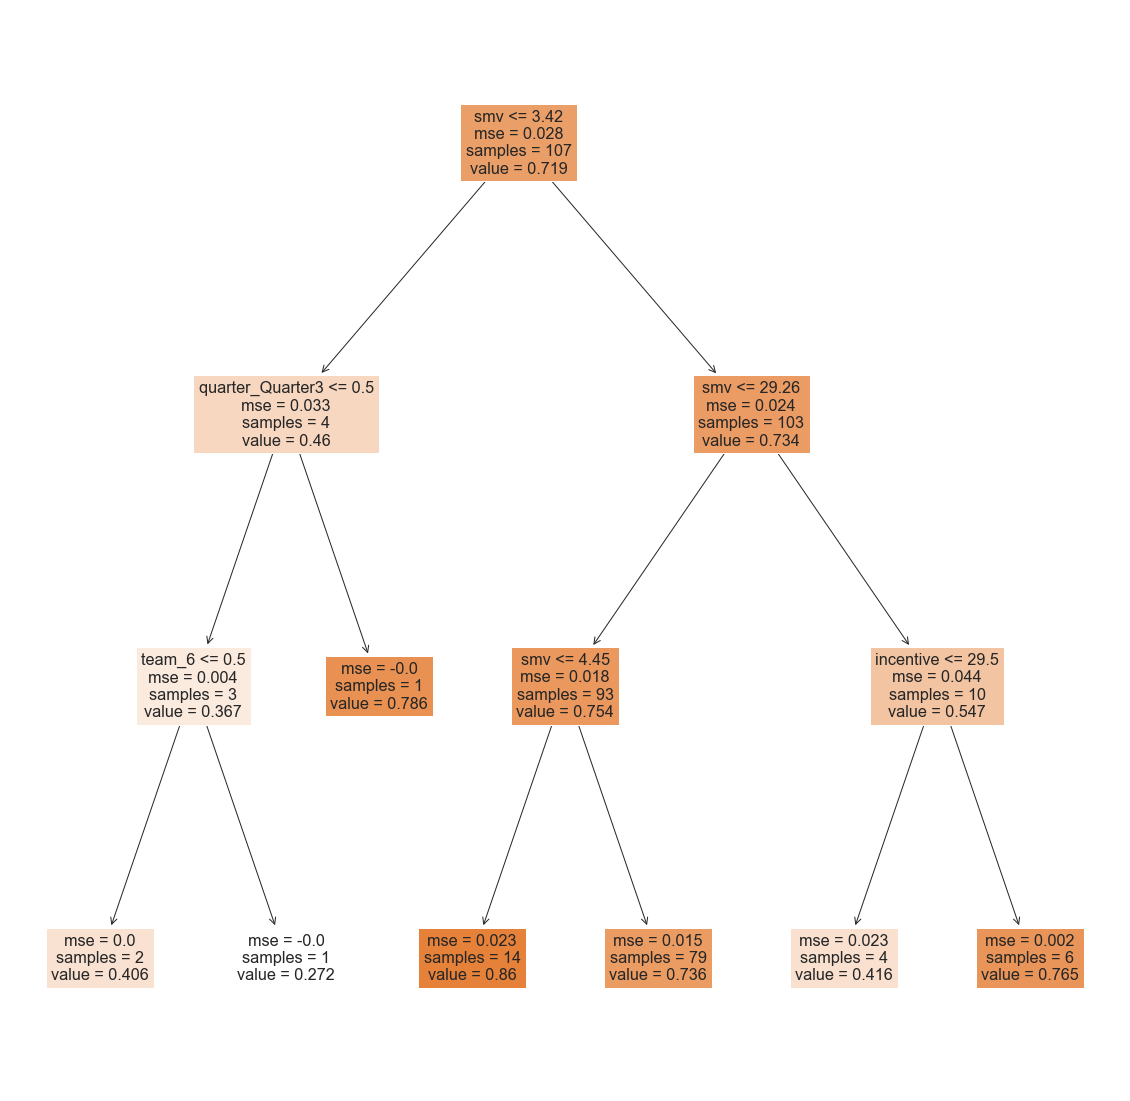

In [40]:
from sklearn import tree # to better visualise,  decision tree max depth is reduced
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0, max_depth=3)
rf_regressor.fit(X3_train,y3_train)
rf_regressor.estimators_[0].tree_.max_depth

plt.figure(figsize=(20,20))
_ = tree.plot_tree(rf_regressor.estimators_[0], feature_names=X3.columns, filled=True)

In [41]:
cluster0.append(metrics.r2_score(y0_test, y0_pred))
cluster1.append(metrics.r2_score(y1_test, y1_pred))
cluster2.append(metrics.r2_score(y2_test, y2_pred))
cluster3.append(metrics.r2_score(y3_test, y3_pred))

all_clusters = [cluster0,cluster1,cluster2,cluster3]
r2_result = pd.DataFrame(all_clusters, columns=['Linear Reg',
                                                'Random Forest Regression'],
                         index=['Cluster0', 'Cluster1','Cluster2','Cluster3'])
r2_result

,Linear Reg,Random Forest Regression
Cluster0,-0.051090,0.100833
Cluster1,0.731027,0.759737
Cluster2,0.798309,0.790052
Cluster3,0.389316,0.601186


## (9) XGBoost comparison

**XGBoost could be better for unbalanced datasets** (e.g. forgery or fraud detection, as ratio of authentic transaction class to unauthentic will be huge). However, this employee dataset has a continuous target variable (but could be further tested for uniform distribution). 

**XGBoost hyperparameters apply to only one tree at the start to adjust itself iteratively** instead of the RF preference for many hyperparameters for model optimisation. Significant more when test data has real-time variations instead of this static dataset and the hyperparameters must be fixed.

**XGBoost straight away prunes the tree with a score called “Similarity score” before entering into the actual modeling.**  Meanwhile, the Random forest might  overfit the data if the majority of the trees in the forest are provided with similar samples. This is not case, firstly as the data is pre-processed and cleaned, secondly through clustering and test/train splits so the majority of trees aren't given similar samples repeatedly. 

In [42]:
import xgboost as xgb

xgbr_cl1=xgb.XGBRegressor(verbosity=0)
xgbr_cl1.fit(X1_train, y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [43]:
score = xgbr_cl1.score(X1_train, y1_train)
print('Training Score:', score)

Training Score: 0.9877920115835196


In [44]:
score_cv = cross_val_score(xgbr_cl1, X1_train, y1_train, cv=10)
print('Mean cross-validation score: %.2f' % score_cv.mean()) 

Mean cross-validation score: 0.76


In [45]:
y1_pred = xgbr_cl1.predict(X1_test)
print('R2 score: %.3f' % r2_score(y1_test, y1_pred, multioutput='uniform_average'))

R2 score: 0.703


In [46]:
mae = metrics.mean_absolute_error(y1_test, y1_pred)
mse = metrics.mean_squared_error(y1_test, y1_pred)
print('MAE: ', mae)
print('MSE: ', mse)

MAE:  0.056895842345690145
MSE:  0.008972619196901248


XGBoost model performance for cluster 1 is superior to RF. Let's see how it compares with the other 3.

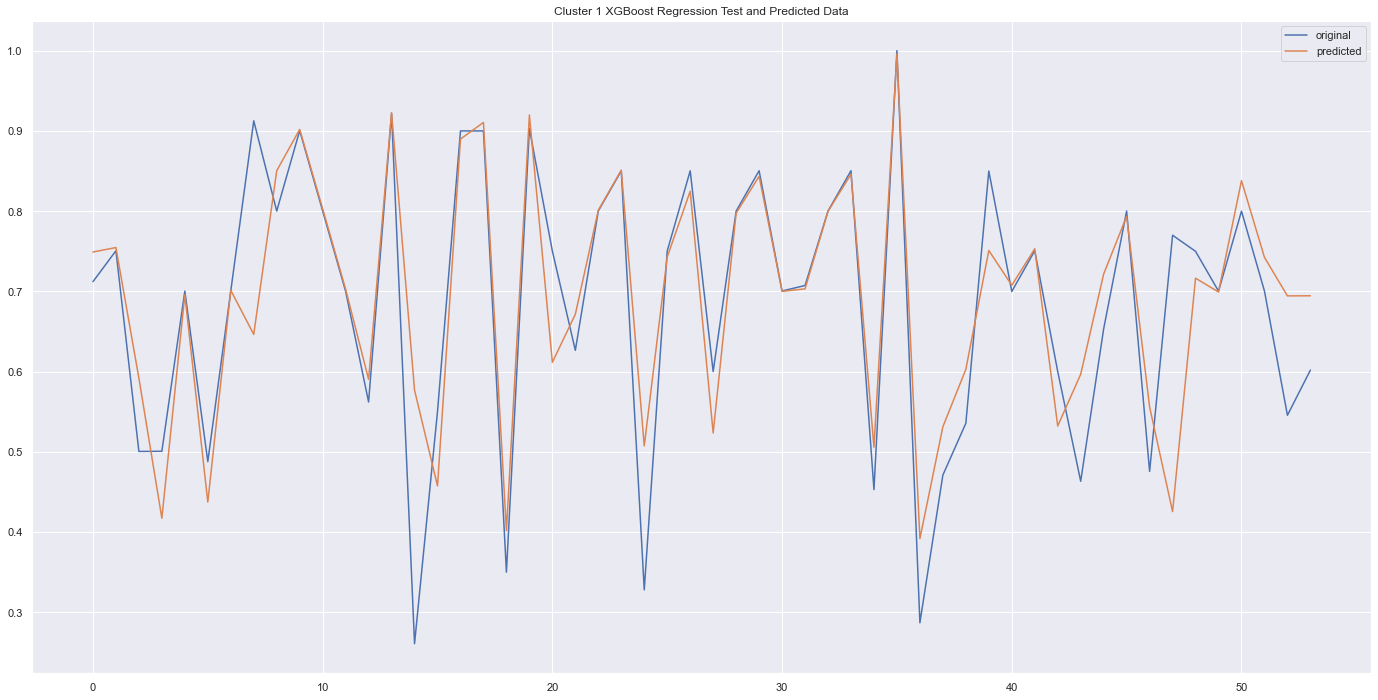

In [47]:
x_ax = range(len(y1_test))
plt.plot(x_ax, y1_test, label='original')
plt.plot(x_ax, y1_pred, label='predicted')
plt.title('Cluster 1 XGBoost Regression Test and Predicted Data')
plt.legend()

In [48]:
xgbr_cl0=xgb.XGBRegressor(verbosity=0)
xgbr_cl0.fit(x0_train, y0_train)
y0_pred = xgbr_cl0.predict(x0_test)

xgbr_res = []
xgbr_res.append(metrics.r2_score(y0_test, y0_pred))
xgbr_res.append(metrics.r2_score(y1_test, y1_pred))

xgbr = xgb.XGBRegressor(verbosity = 0)
xgbr.fit(X2_train, y2_train)
y2_pred = xgbr.predict(X2_test)
xgbr_res.append(metrics.r2_score(y2_test, y2_pred))

xgbr = xgb.XGBRegressor(verbosity = 0)
xgbr.fit(X3_train, y3_train)
y2_pred = xgbr.predict(X3_test)
xgbr_res.append(metrics.r2_score(y3_test, y3_pred))

In [49]:
r2_result['XGBRegressor'] = xgbr_res
r2_result

,Linear Reg,Random Forest Regression,XGBRegressor
Cluster0,-0.051090,0.100833,0.007018
Cluster1,0.731027,0.759737,0.703255
Cluster2,0.798309,0.790052,0.643533
Cluster3,0.389316,0.601186,0.601186


Conclusion: Both Random Forest and XGBoost showed improvements in most accurately modelling the function of actual productivity. Random Forest being the most acceptable.